In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from IPython.display import display
from sklearn.model_selection import (GridSearchCV, ParameterGrid,
                                     RandomizedSearchCV)
from xgboost import XGBClassifier
import pickle
import random
from tqdm.notebook import trange, tqdm

from tools import Modelisation, datasets

t = time.time()

In [2]:
df = pd.read_csv('data/df_train_prepro.csv').sample(frac=1)
df.shape

(1610494, 48)

**Définition des variables quantitatives, des variables catégorielles et des datasets :**

In [3]:
datasets_df = datasets(df)
X_quant = datasets_df['X_quant']
X_cat = datasets_df['X_cat']
X = datasets_df['X']
y = datasets_df['y']

Columns_quant :


['contextid',
 'campaignctrlast24h',
 'dayssincelastvisitdouble',
 'ltf_nbglobaldisplay_4w',
 'ltf_nbpartnerdisplayssincelastclick',
 'ltf_nbpartnerdisplay_90d',
 'ltf_nbpartnerclick_90d',
 'ltf_nbpartnersales_90d',
 'nbdayssincelastclick',
 'nbdisplay_1hour',
 'nbdisplayglobalapprox_1d_sum_xdevice',
 'display_size',
 'zonecostineuro']


Columns_cat :


['display_env',
 'target_env',
 'campaignscenario',
 'campaignvertical',
 'is_interstitial',
 'device_type',
 'hour',
 'weekday']


Nombre de variables pour X_quant : 13



Index(['contextid', 'campaignctrlast24h', 'dayssincelastvisitdouble',
       'ltf_nbglobaldisplay_4w', 'ltf_nbpartnerdisplayssincelastclick',
       'ltf_nbpartnerdisplay_90d', 'ltf_nbpartnerclick_90d',
       'ltf_nbpartnersales_90d', 'nbdayssincelastclick', 'nbdisplay_1hour',
       'nbdisplayglobalapprox_1d_sum_xdevice', 'display_size',
       'zonecostineuro'],
      dtype='object')


Nombre de variables pour X_cat : 50



Index(['display_env_app_ios', 'display_env_other', 'display_env_web',
       'target_env_2', 'campaignscenario_5', 'campaignscenario_6',
       'campaignscenario_11', 'campaignscenario_12', 'campaignscenario_13',
       'campaignscenario_17', 'campaignvertical_20.0', 'campaignvertical_23.0',
       'campaignvertical_129.0', 'campaignvertical_200002.0',
       'is_interstitial_True', 'device_type_Desktop',
       'device_type_Desktop - Safari', 'device_type_Mobile - Other',
       'device_type_Unknown', 'device_type_iPad', 'device_type_iPhone',
       'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7',
       'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13',
       'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19',
       'hour_20', 'hour_21', 'hour_22', 'hour_23', 'weekday_Monday',
       'weekday_Saturday', 'weekday_Sunday', 'weekday_Thursday',
       'weekday_Tuesday', 'weekday_Wednesday'],
      dtype='object')


Nombre de variables pour X_quant_cat : 63


In [4]:
len(y[y == 0]) / (len(y[y == 1]))

16.552685500043594

# XGBoost
## Variables quantitatives

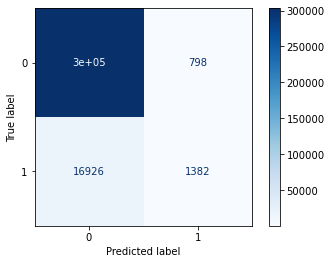

f1 : 0.1349
recall : 0.0755
negative predictive value : 0.9471
precision : 0.6339
roc_auc : 0.8263
Wall time: 34 s


In [5]:
%%time
m = Modelisation(X_quant, y, XGBClassifier(n_jobs=-1), scaling=False)
m.show_conf_matrix()
m.show_metrics_score()

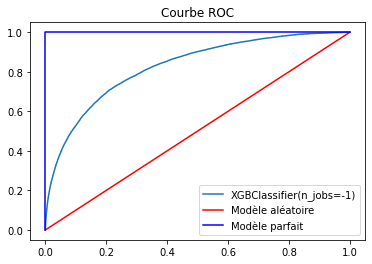

In [6]:
m.show_ROC()

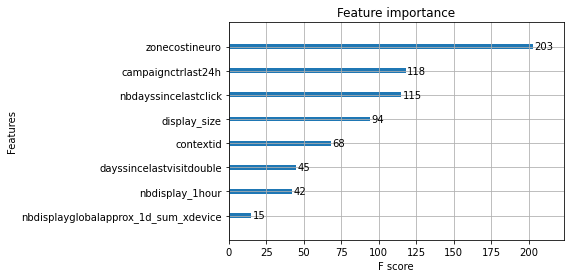

In [7]:
m.plot_importance()

Affichage d'un arbre (par défaut le premier parmi les autres) :

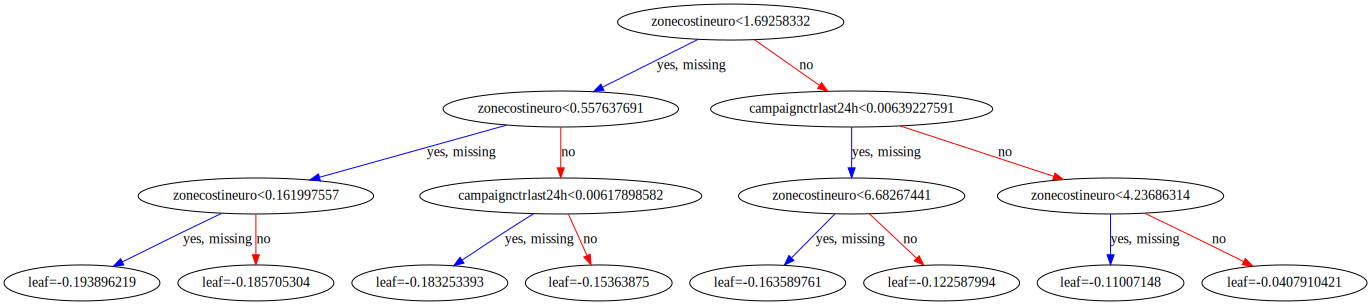

In [8]:
m.show_graph()

## Categorical variables

In [9]:
# Nombre de valeurs distinctes
for column in columns_cat:
    print(f"{column} : {len(set(df[column]))}")

display_env : 4
target_env : 2
campaignscenario : 7
campaignvertical : 34
is_interstitial : 3
device_type : 7
hour : 24
weekday : 7


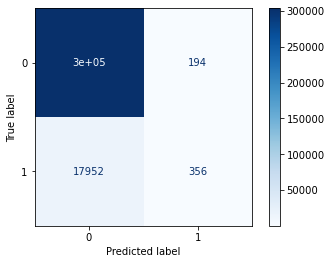

f1 : 0.0378
recall : 0.0194
negative predictive value : 0.9442
precision : 0.6473
roc_auc : 0.6922
Wall time: 52.6 s


In [10]:
%%time
m = Modelisation(X_cat, y, XGBClassifier(n_jobs=-1), scaling=False)
m.show_conf_matrix()
m.show_metrics_score()

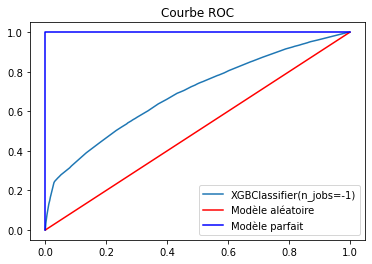

In [11]:
m.show_ROC()

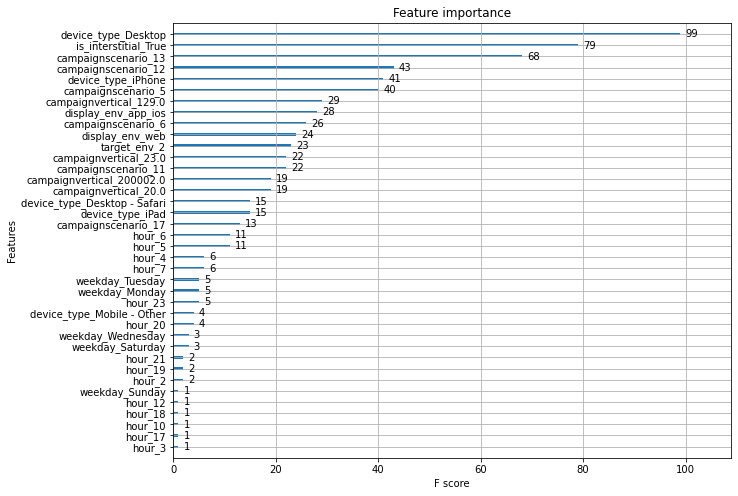

In [12]:
fig, ax = plt.subplots(figsize=(10, 8))
m.plot_importance(ax=ax)

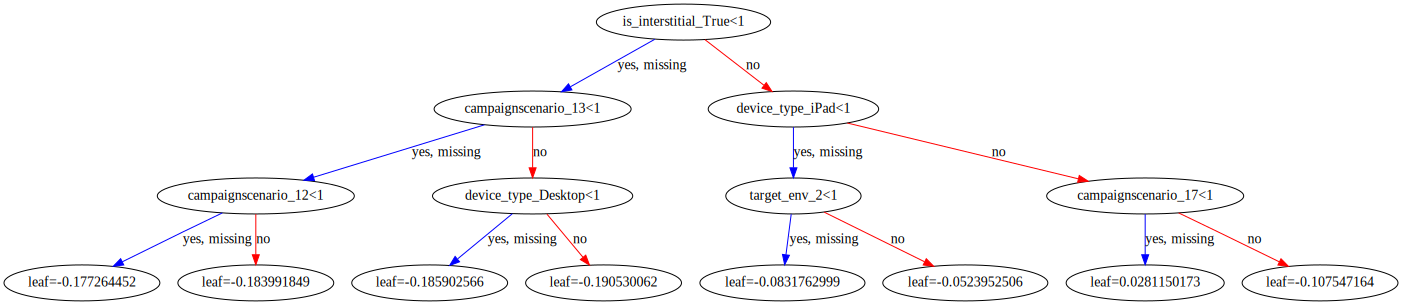

In [13]:
m.show_graph()

## Quantitative + categorical

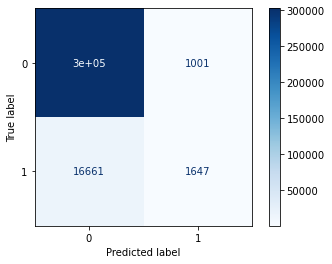

f1 : 0.1572
recall : 0.0900
negative predictive value : 0.9478
precision : 0.6220
roc_auc : 0.8330
Wall time: 1min 12s


In [14]:
%%time
m = Modelisation(X, y, XGBClassifier(n_jobs=-1), scaling=False)
m.show_conf_matrix()
m.show_metrics_score()

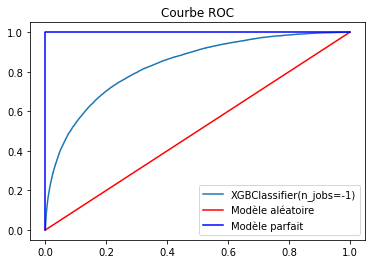

In [15]:
m.show_ROC()

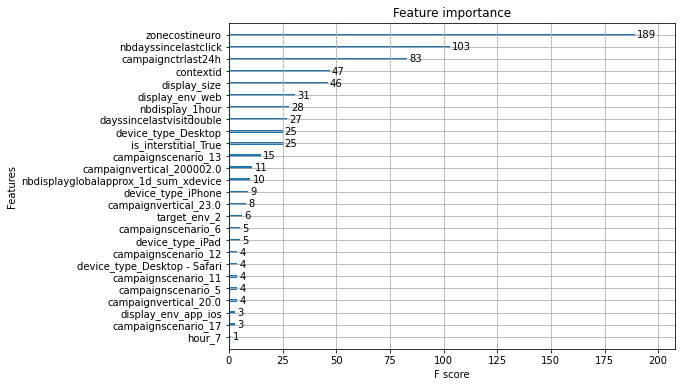

In [16]:
fig, ax = plt.subplots(figsize=(8, 6))
m.plot_importance(ax=ax)

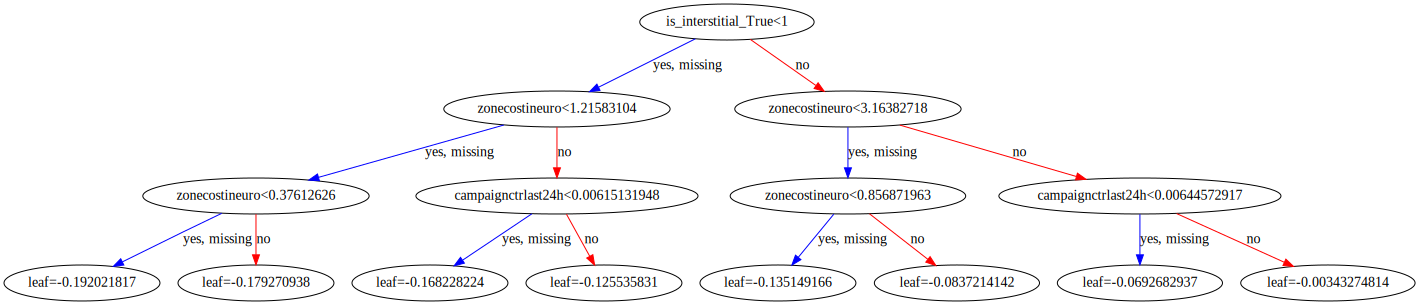

In [17]:
m.show_graph()

## Tuning des hyperparamètres avec GridSearchCV

On calcule le GridSearchCV sur un dataset plus petit pour avoir un temps de calcul raisonnable.

In [18]:
def SearchCV(random, params, data_frac, n_iter=5000):
    print('RandomizedSearchCV' if random else 'GridSearchCV')  
    print('******************')
    print(f"\nNombre total de combinaisons de paramètres : {len(ParameterGrid(params))}")
    print(f"Pourcentage des données : {data_frac*100}%")
    if random:
        print(f"Nombre de combinaisons aléatoires testées : {n_iter}")    
    
    df = pd.read_csv('data/df_train_prepro.csv').sample(frac=data_frac)
    datasets_df = datasets(df, verbose=False)
    X = datasets_df['X']
    y = datasets_df['y']

    model = XGBClassifier(booster='gbtree', objective='binary:logistic', n_jobs=1)
    
    if random:
        search = RandomizedSearchCV(model, params, n_iter=n_iter, scoring=['f1', 'recall'], refit=False, n_jobs=-1, cv=5, verbose=2)
    else:
        search = GridSearchCV(model, params, scoring=['f1', 'recall'], refit=False, n_jobs=-1, cv=5, verbose=2)
    
    t1 = time.time()
    search.fit(X, y)
    temps = time.strftime('%H:%M:%S', time.gmtime(time.time()-t1))
    
    results = pd.DataFrame(search.cv_results_)
    
    len_grid = len(ParameterGrid(params))
    
    dico = {'type': 'RandomizedSearchCV' if random else 'GridSearchCV', 
            'len_grid': len_grid,
            'n_iter': n_iter,
            'data_frac': data_frac,
            'temps': temps,
            'params': params
           }
    if not random: del dico['n_iter']
    
    filename = 'xgboost_cv_'
    if random:
        filename += f'Randomized{n_iter}_'
    else:
        filename += 'Grid_'
    filename += f'{len_grid}_'
    filename += f'{data_frac}'
    
    print(f"\nTemps : {temps}")
    print(f"Exportation : {filename}")
    
    pickle.dump((dico, results), open('backups/'+filename+'.pkl', 'wb'))    

### Calcul et sauvegarde

In [19]:
# params = {
#         'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.5],
#         'gamma': [0.5, 1, 1.5, 2, 5],
#         'max_depth': [2, 4, 6, 8],
#         'min_child_weight': [1, 5, 10, 15],
#         'subsample': [0.6, 0.8, 1.0],
#         'colsample_bytree': [0.6, 0.8, 1.0],    
#         'scale_pos_weight': [1, 16.5]   # A typical value to consider: sum(negative instances) / sum(positive instances)
#         }


# SearchCV(True, params, 0.001, n_iter=2)

### Restauration des résultats

In [20]:
filename = 'xgboost_cv_Randomized5000_10080_0.01'
dico, results = pickle.load(open('backups/'+filename+'.pkl', 'rb'))

for key, value in dico.items():
    print(f"{key} : {value}") 

type : RandomizedSearchCV
len_grid : 10080
n_iter : 5000
data_frac : 0.01
temps : 04:32:58
params : {'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.5], 'gamma': [0.5, 1, 1.5, 2, 5], 'max_depth': [2, 4, 6, 8], 'min_child_weight': [1, 5, 10, 15], 'subsample': [0.6, 0.8, 1.0], 'colsample_bytree': [0.6, 0.8, 1.0], 'scale_pos_weight': [1, 16.5]}


In [21]:
results.loc[:, ~results.columns.str.startswith('split')].head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_scale_pos_weight,param_min_child_weight,param_max_depth,param_learning_rate,param_gamma,param_colsample_bytree,params,mean_test_f1,std_test_f1,rank_test_f1,mean_test_recall,std_test_recall,rank_test_recall
0,5.209268,0.133173,0.029122,0.000746,0.6,16.5,10,4,0.01,1,1.0,"{'subsample': 0.6, 'scale_pos_weight': 16.5, '...",0.253964,0.010000,1961,0.731442,0.033171,241
1,2.176579,0.068606,0.022739,0.001164,1.0,16.5,15,2,0.001,1,0.8,"{'subsample': 1.0, 'scale_pos_weight': 16.5, '...",0.211513,0.011313,2500,0.780038,0.028121,66
2,3.048247,0.045057,0.028125,0.003858,0.6,1,15,4,0.0001,2,0.6,"{'subsample': 0.6, 'scale_pos_weight': 1, 'min...",0.000000,0.000000,4806,0.000000,0.000000,4806
3,6.055006,0.634850,0.040492,0.002054,0.6,1,1,4,0.5,2,1.0,"{'subsample': 0.6, 'scale_pos_weight': 1, 'min...",0.221713,0.027906,2334,0.160895,0.018924,2478
4,5.688186,0.318117,0.030918,0.001093,0.6,1,5,4,0.01,5,0.8,"{'subsample': 0.6, 'scale_pos_weight': 1, 'min...",0.061018,0.024439,4357,0.032437,0.014091,4353
5,8.047277,0.260365,0.042287,0.001017,1.0,1,5,8,0.01,0.5,0.8,"{'subsample': 1.0, 'scale_pos_weight': 1, 'min...",0.149166,0.025365,3949,0.085657,0.016957,3966
6,4.908073,0.024876,0.045478,0.001197,1.0,1,10,6,0.1,2,0.6,"{'subsample': 1.0, 'scale_pos_weight': 1, 'min...",0.179742,0.010352,3424,0.106486,0.005975,3519
7,11.396121,0.122519,0.062832,0.000892,0.8,1,1,8,0.3,0.5,1.0,"{'subsample': 0.8, 'scale_pos_weight': 1, 'min...",0.193910,0.029472,2919,0.124983,0.019108,2896
8,3.079364,0.031624,0.030919,0.000631,0.6,1,10,2,0.5,1.5,0.8,"{'subsample': 0.6, 'scale_pos_weight': 1, 'min...",0.213286,0.025573,2469,0.135435,0.018997,2657
9,2.616003,0.005007,0.029322,0.001017,1.0,1,1,2,0.2,0.5,0.8,"{'subsample': 1.0, 'scale_pos_weight': 1, 'min...",0.164313,0.022765,3806,0.097244,0.015414,3790


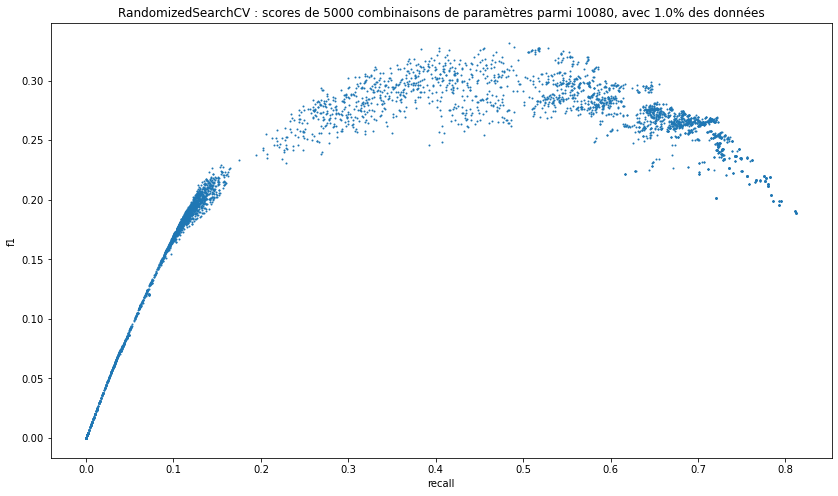

In [22]:
plt.figure(figsize=(14, 8))
plt.scatter(results['mean_test_recall'], results['mean_test_f1'], marker='o', s=1)
plt.xlabel('recall')
plt.ylabel('f1')
if dico['type'] == 'RandomizedSearchCV':
    plt.title(f"RandomizedSearchCV : scores de {dico['n_iter']} combinaisons de paramètres parmi {dico['len_grid']}, avec {dico['data_frac']*100}% des données")
else:
    plt.title(f"GridSearchCV : scores de {dico['len_grid']} combinaisons de paramètres, avec {dico['data_frac']*100}% des données")
plt.show()

**Paramètres donnant le meilleur recall**

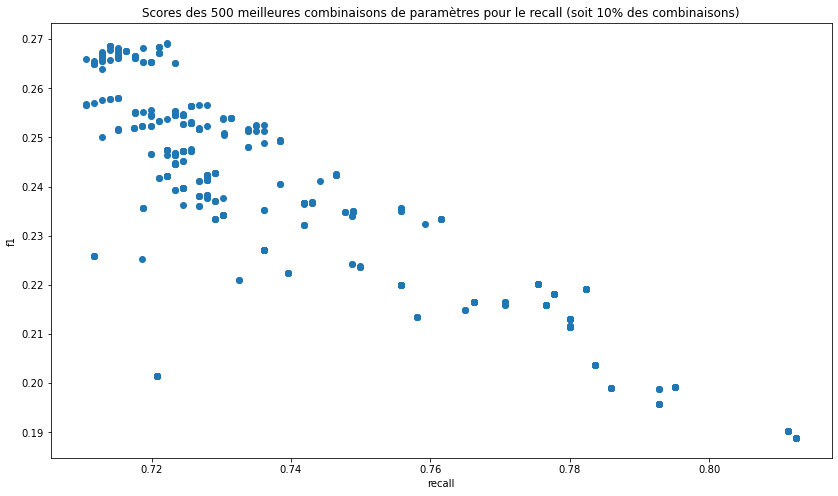

In [23]:
if dico['type'] == 'RandomizedSearchCV':
    n = int(0.1 * dico['n_iter'])
else:
    n = int(0.1 * dico['len_grid'])

results_sort = results.sort_values(by='mean_test_recall', ascending=False)
plt.figure(figsize=(14, 8))
plt.scatter(results_sort['mean_test_recall'][:500], results_sort['mean_test_f1'][:500], marker='o')
plt.xlabel('recall')
plt.ylabel('f1')
plt.title(f"Scores des {n} meilleures combinaisons de paramètres pour le recall (soit 10% des combinaisons)")
plt.show()

In [24]:
results_sort.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_scale_pos_weight,param_min_child_weight,param_max_depth,param_learning_rate,param_gamma,...,std_test_f1,rank_test_f1,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,split4_test_recall,mean_test_recall,std_test_recall,rank_test_recall
3661,3.045853,0.007052,0.023737,0.001596,0.8,16.5,15,2,0.0001,2,...,0.013815,3089,0.790698,0.820809,0.861272,0.786127,0.803468,0.812475,0.027204,1
3663,2.948713,0.037823,0.024534,0.001017,0.8,16.5,15,2,0.0001,0.5,...,0.013815,3089,0.790698,0.820809,0.861272,0.786127,0.803468,0.812475,0.027204,1
1271,3.919916,0.584541,0.024934,0.002600,0.8,16.5,5,2,0.0001,2,...,0.013815,3089,0.790698,0.820809,0.861272,0.786127,0.803468,0.812475,0.027204,1
1256,3.456325,0.012984,0.028125,0.002631,0.8,16.5,15,2,0.0001,1.5,...,0.013815,3089,0.790698,0.820809,0.861272,0.786127,0.803468,0.812475,0.027204,1
2026,2.779166,0.055542,0.023338,0.003816,0.8,16.5,5,2,0.0001,1,...,0.013815,3089,0.790698,0.820809,0.861272,0.786127,0.803468,0.812475,0.027204,1
864,2.781263,0.094631,0.021542,0.001017,0.8,16.5,1,2,0.0001,1,...,0.013815,3089,0.790698,0.820809,0.861272,0.786127,0.803468,0.812475,0.027204,1
601,3.363205,0.054864,0.026330,0.001017,0.8,16.5,10,2,0.0001,1.5,...,0.013815,3089,0.790698,0.820809,0.861272,0.786127,0.803468,0.812475,0.027204,1
2020,2.801506,0.018206,0.022939,0.001093,0.8,16.5,5,2,0.0001,5,...,0.013815,3089,0.790698,0.820809,0.861272,0.786127,0.803468,0.812475,0.027204,1
4522,3.349241,0.092840,0.027128,0.001163,0.8,16.5,15,2,0.0001,5,...,0.013815,3089,0.790698,0.820809,0.861272,0.786127,0.803468,0.812475,0.027204,1
2862,2.493730,0.044693,0.022141,0.001323,1.0,16.5,5,2,0.001,0.5,...,0.017304,3030,0.796512,0.803468,0.861272,0.791908,0.803468,0.811325,0.025356,10


In [25]:
best_params = results_sort.iloc[0].params
best_params

{'subsample': 0.8,
 'scale_pos_weight': 16.5,
 'min_child_weight': 15,
 'max_depth': 2,
 'learning_rate': 0.0001,
 'gamma': 2,
 'colsample_bytree': 1.0}

**Analyse sur la base complète**

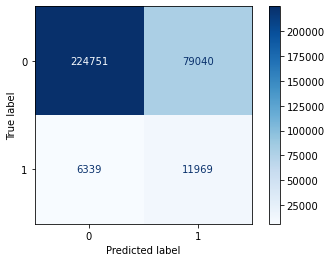

f1 : 0.2190
recall : 0.6538
negative predictive value : 0.9726
precision : 0.1315
roc_auc : 0.7553
Wall time: 1min 1s


In [26]:
%%time
m = Modelisation(X, y, XGBClassifier(**best_params, n_jobs=-1), scaling=False)
m.show_conf_matrix()
m.show_metrics_score()

Le recall est moins bon que celui trouvé auparavant. Essayons avec le `learning_rate` par défaut.

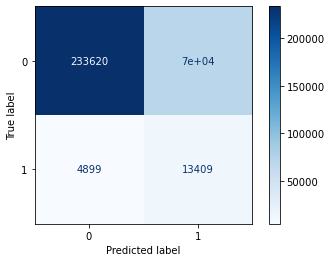

f1 : 0.2632
recall : 0.7324
negative predictive value : 0.9795
precision : 0.1604
roc_auc : 0.8301
Wall time: 1min 1s


In [27]:
%%time
if 'learning_rate' in best_params:
    del best_params['learning_rate']
m = Modelisation(X, y, XGBClassifier(**best_params, n_jobs=-1), scaling=False)
m.show_conf_matrix()
m.show_metrics_score()

Nous reproduisons le graphique f1 vs recall en prenant 10% des meilleures combinaisons (selon le recall), en fittant le modèle sur 10% des données.

  0%|          | 0/50 [00:00<?, ?it/s]

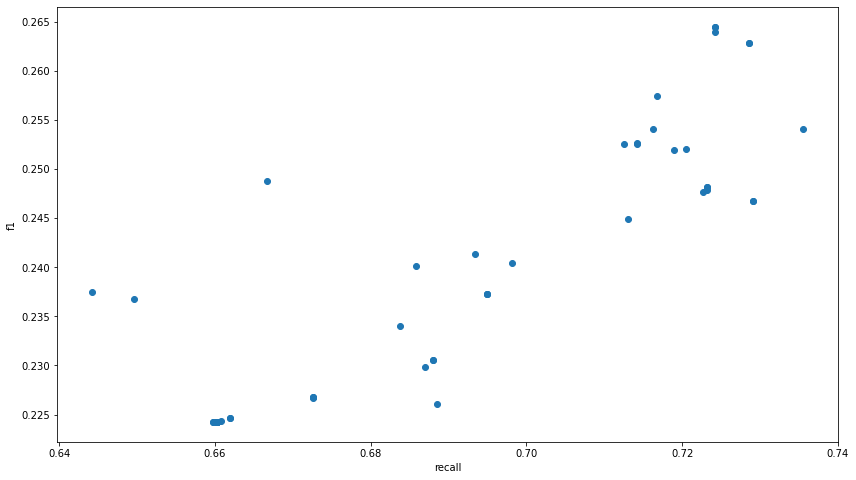

Wall time: 5min 9s


In [28]:
%%time

df_small = pd.read_csv('data/df_train_prepro.csv').sample(frac=0.1)
datasets_df_small = datasets(df_small, verbose=False)
X_small = datasets_df_small['X']
y_small = datasets_df_small['y']

f1_list = []
recall_list = []
params_list = []


nb_tot = 500
nb = 50

random.seed(1)
sample = random.sample(list(range(nb_tot)), nb)
for j in trange(nb):
    i = sample[j]
    params = results_sort.iloc[i].params
    m = Modelisation(X_small, y_small, XGBClassifier(**params, n_jobs=-1), scaling=False)
    params_list.append(params)
    f1_list.append(m.metrics_score['f1'])
    recall_list.append(m.metrics_score['recall'])
    
plt.figure(figsize=(14, 8))
plt.scatter(recall_list, f1_list, marker='o')
plt.xlabel('recall')
plt.ylabel('f1')
plt.show()
 
# dico_ = {'params': params_list, 'f1': f1_list, 'recall': recall_list}     
# r = pd.DataFrame(dico_).sort_values(by='recall', ascending=False)

Même graphique avec le `learning_rate` par défaut :

  0%|          | 0/50 [00:00<?, ?it/s]

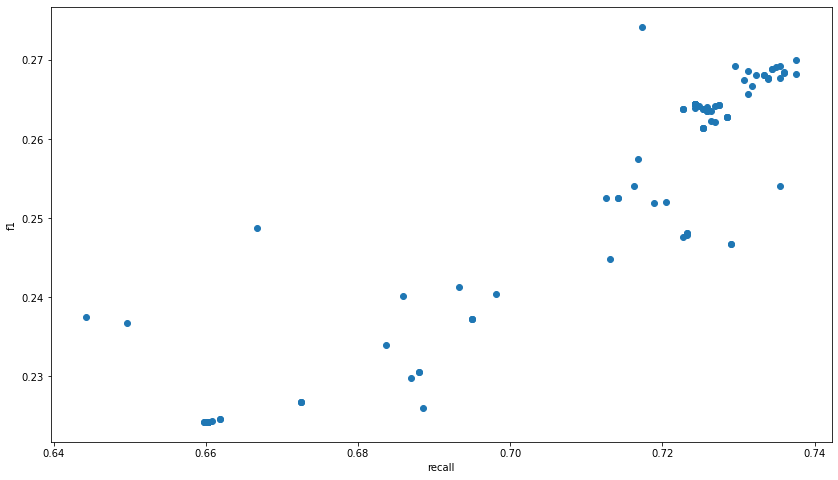

Wall time: 4min 50s


In [29]:
%%time

sample = random.sample(list(range(nb_tot)), nb)
for j in trange(nb):
    i = sample[j]
    params = results_sort.iloc[i].params
    if 'learning_rate' in params:
        del params['learning_rate']
    m = Modelisation(X_small, y_small, XGBClassifier(**params, n_jobs=-1), scaling=False)
    params_list.append(params)
    f1_list.append(m.metrics_score['f1'])
    recall_list.append(m.metrics_score['recall'])
    
plt.figure(figsize=(14, 8))
plt.scatter(recall_list, f1_list, marker='o')
plt.xlabel('recall')
plt.ylabel('f1')
plt.show()

**Test de paramètres**

In [30]:
params = {'colsample_bytree': 1.0, 
          'gamma': 1,
          'min_child_weight': 15,
          'scale_pos_weight': 16.5, 
          'subsample': 0.8}

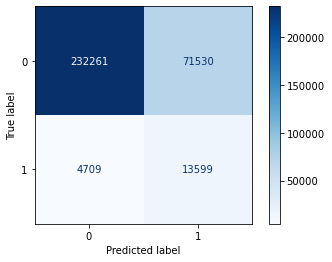

f1 : 0.2629
recall : 0.7428
negative predictive value : 0.9801
precision : 0.1597
roc_auc : 0.8343
Wall time: 1min 26s


In [31]:
%%time
m = Modelisation(X, y, XGBClassifier(**params, n_jobs=-1), scaling=False)
m.show_conf_matrix()
m.show_metrics_score()

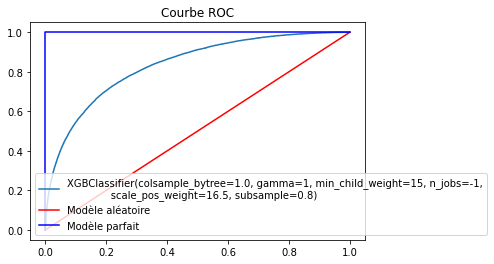

In [32]:
m.show_ROC()

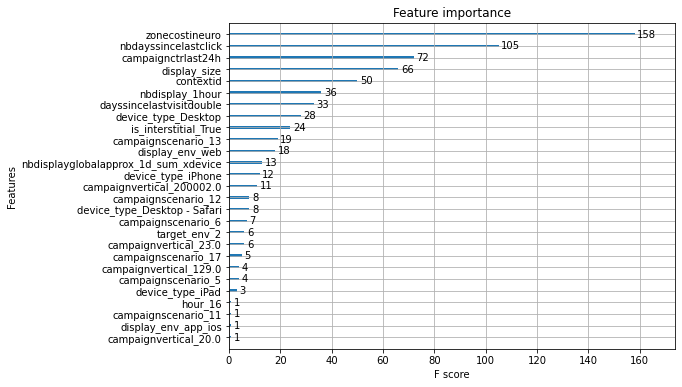

In [33]:
fig, ax = plt.subplots(figsize=(8, 6))
m.plot_importance(ax=ax)

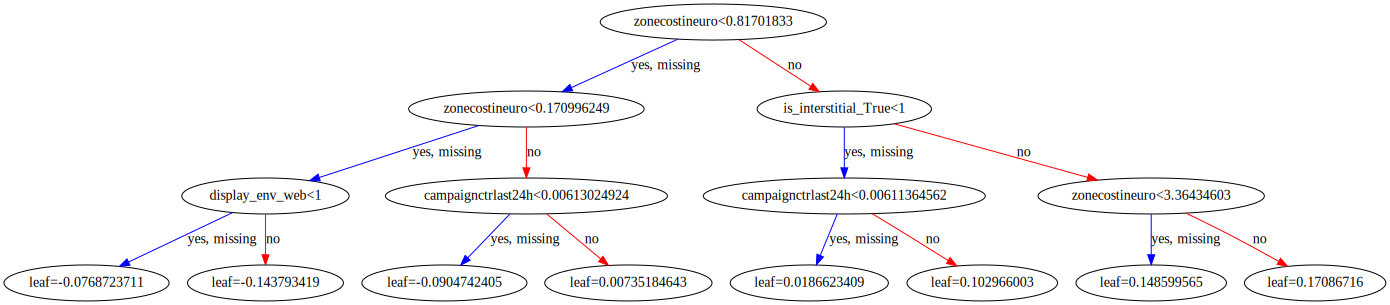

In [34]:
m.show_graph()

In [35]:
print(f"Temps d'exécution total : {time.strftime('%H:%M:%S', time.gmtime(time.time()-t))}")

Temps d'exécution total : 00:16:41
